## p59 Viz model while training

In [1]:
seed=1
frac_train=0.25 
weight_decay = 1.0 #@param
freq_penalty_weight = 1e-3 
run_name='grok_1764706121'

In [2]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import random
import time

# from google.colab import drive
from pathlib import Path
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "colab"
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc

# import comet_ml
import itertools

In [3]:
# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient 
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []
    
    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name
    
    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output, 
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")
    
    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")
    
    def forward(self, x):
        return x

In [4]:
# Define network architecture
# I defined my own transformer from scratch so I'd fully understand each component 
# - I expect this wasn't necessary or particularly important, and a bunch of this 
# replicates existing PyTorch functionality

# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
    
    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']
        
    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache
    
    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')
    
    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

In [5]:
# Helper functions
def cuda_memory():
    print(torch.cuda.memory_allocated()/1e9)

def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly 
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes 
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

def full_loss(model, data):
    # Take the final position only
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to('cuda')
    return cross_entropy_high_precision(logits, labels)

def test_logits(logits, bias_correction=False, original_logits=None, mode='all'):
    # Calculates cross entropy loss of logits representing a batch of all p^2 
    # possible inputs
    # Batch dimension is assumed to be first
    if logits.shape[1]==p*p:
        logits = logits.T
    if logits.shape==torch.Size([p*p, p+1]):
        logits = logits[:, :-1]
    logits = logits.reshape(p*p, p)
    if bias_correction:
        # Applies bias correction - we correct for any missing bias terms, 
        # independent of the input, by centering the new logits along the batch 
        # dimension, and then adding the average original logits across all inputs
        logits = einops.reduce(original_logits - logits, 'batch ... -> ...', 'mean') + logits
    if mode=='train':
        return cross_entropy_high_precision(logits[is_train], labels[is_train])
    elif mode=='test':
        return cross_entropy_high_precision(logits[is_test], labels[is_test])
    elif mode=='all':
        return cross_entropy_high_precision(logits, labels)

def unflatten_first(tensor):
    if tensor.shape[0]==p*p:
        return einops.rearrange(tensor, '(x y) ... -> x y ...', x=p, y=p)
    else: 
        return tensor
def cos(x, y):
    return (x.dot(y))/x.norm()/y.norm()
def mod_div(a, b):
    return (a*pow(b, p-2, p))%p
def normalize(tensor, axis=0):
    return tensor/(tensor).pow(2).sum(keepdim=True, axis=axis).sqrt()
def extract_freq_2d(tensor, freq):
    # Takes in a pxpx... or batch x ... tensor, returns a 3x3x... tensor of the 
    # Linear and quadratic terms of frequency freq
    tensor = unflatten_first(tensor)
    # Extracts the linear and quadratic terms corresponding to frequency freq
    index_1d = [0, 2*freq-1, 2*freq]
    # Some dumb manipulation to use fancy array indexing rules
    # Gets the rows and columns in index_1d
    return tensor[[[i]*3 for i in index_1d], [index_1d]*3]
def get_cov(tensor, norm=True):
    # Calculate covariance matrix
    if norm:
        tensor = normalize(tensor, axis=1)
    return tensor @ tensor.T
def is_close(a, b):
    return ((a-b).pow(2).sum()/(a.pow(2).sum().sqrt())/(b.pow(2).sum().sqrt())).item()

In [6]:
def compute_frequency_components(m):
    """
    Compute canonical frequency components of a real 2D signal m using fft2.

    Returns:
        components: list of dicts with keys:
            - 'kx': frequency index in x (rows)
            - 'ky': frequency index in y (cols)
            - 'coeff': complex FFT coefficient at (kx, ky)
        Nx, Ny: dimensions of the input
    """
    m = np.asarray(m)
    Nx, Ny = m.shape
    F = np.fft.fft2(m)

    components = []
    seen = set()

    for kx in range(Nx):
        for ky in range(Ny):
            # Conjugate partner indices for real-valued input
            kx_conj = (-kx) % Nx
            ky_conj = (-ky) % Ny

            pair = tuple(sorted([(kx, ky), (kx_conj, ky_conj)]))
            if pair in seen:
                continue
            seen.add(pair)

            # Always store the "smaller" one in lexicographic order
            kx_rep, ky_rep = pair[0]
            coeff = F[kx_rep, ky_rep]
            components.append({
                "kx": kx_rep,
                "ky": ky_rep,
                "coeff": coeff
            })

    return components, Nx, Ny


def components_to_terms(components, Nx, Ny, num_freqs, include_dc=True):
    """
    Convert FFT components into real cosine terms with amplitude & phase.

    Args:
        components: output from compute_frequency_components
        Nx, Ny: grid size
        num_freqs: number of *non-DC* frequencies to keep
        include_dc: whether to include the constant (DC) term

    Returns:
        terms: list of dicts with keys:
            - 'kx', 'ky'
            - 'amplitude'  (real, >= 0)
            - 'phase'      (in radians)
            - 'is_dc'      (bool, True only for the constant term)
    """
    terms = []
    dc_term = None

    for c in components:
        kx = c["kx"]
        ky = c["ky"]
        coeff = c["coeff"]

        # DC component (constant offset)
        if kx == 0 and ky == 0:
            dc_value = coeff.real / (Nx * Ny)
            dc_term = {
                "kx": 0,
                "ky": 0,
                "amplitude": dc_value,  # directly the constant offset
                "phase": 0.0,
                "is_dc": True,
            }
        else:
            # For real signals, combine (k, l) and (-k, -l) into:
            #   2*|F|/(Nx*Ny) * cos(2π(kx i/Nx + ky j/Ny) + phase)
            amp = 2.0 * np.abs(coeff) / (Nx * Ny)
            phase = np.angle(coeff)
            terms.append({
                "kx": kx,
                "ky": ky,
                "amplitude": amp,
                "phase": phase,
                "is_dc": False,
            })

    # Sort non-DC terms by amplitude (largest first)
    terms.sort(key=lambda t: t["amplitude"], reverse=True)

    # Keep only the top num_freqs
    terms = terms[:num_freqs]

    # Optionally prepend DC term
    if include_dc and dc_term is not None:
        terms = [dc_term] + terms

    return terms

def generate_python_reconstructor(terms, Nx, Ny, func_name="recon_func", decimals=4):
    """
    Generate a Python function as a string that reconstructs the signal
    using explicit 1D and product-of-cosine terms from a sparse Fourier representation.

    Types of terms:
      - DC term (constant)
      - Row-only:   A * cos(2π * (kx*i/Nx) + φ)
      - Col-only:   B * cos(2π * (ky*j/Ny) + φ)
      - Product:    C * cos(2π * (kx*i/Nx) + φ) * cos(2π * (ky*j/Ny) + φ)

    You must have `import numpy as np` in the scope where you paste/run this.
    """
    lines = []
    lines.append(f"def {func_name}(i, j):")

    if not terms:
        lines.append("    return 0.0")
        return "\n".join(lines)

    # Separate DC from others
    dc_terms = [t for t in terms if t.get("is_dc", False)]
    non_dc_terms = [t for t in terms if not t.get("is_dc", False)]

    if dc_terms:
        dc_val = round(dc_terms[0]["amplitude"], decimals)
        lines.append(f"    val = {dc_val}")
    else:
        lines.append("    val = 0.0")

    for t in non_dc_terms:
        kx, ky = t["kx"], t["ky"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        if kx != 0 and ky == 0:
            # Row-only cosine
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({kx}*i)/{Nx}) + {phi})"
            )
        elif kx == 0 and ky != 0:
            # Column-only cosine
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({ky}*j)/{Ny}) + {phi})"
            )
        else:
            # Product-of-cosines term (your desired "third" type)
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({kx}*i)/{Nx}) + {phi})"
                f" * np.cos(2*np.pi*(({ky}*j)/{Ny}) + {phi})"
            )

        lines.append(line)

    lines.append("    return val")

    return "\n".join(lines)

In [7]:
def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For all CUDA devices
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # Set to False for determinism

In [8]:
def embedding_frequency_penalty(model: Transformer) -> torch.Tensor:
    """
    Encourage neighboring tokens in the embedding space to be similar.
    This is a graph-Laplacian-style smoothness penalty on W_E, which
    corresponds to penalizing high-frequency Fourier modes on Z_p.

    W_E has shape [d_model, d_vocab].
    We smooth along the vocab dimension (the modular arithmetic axis).
    """
    E = model.embed.W_E  # [d_model, d_vocab]

    # Differences between consecutive tokens (0-1, 1-2, ..., (V-2)-(V-1))
    diff = E[:, 1:] - E[:, :-1]  # [d_model, d_vocab-1]

    # Wrap-around difference to respect modular structure: token V-1 vs 0
    wrap = E[:, :1] - E[:, -1:]  # [d_model, 1]

    # Mean squared differences (Laplacian smoothness)
    penalty = (diff.pow(2).mean() + wrap.pow(2).mean())
    return penalty


In [9]:
root = Path('/home/stephen/grokking')

p=113
# seed=2 ##Set at top

lr=1e-3 #@param
p=113 #@param
d_model = 128 #@param
fn_name = 'add' #@param ['add', 'subtract', 'x2xyy2','rand']
num_epochs = 12000 #@param
save_models = True #@param
save_every = 100 # Maybe crank this down
# Stop training when test loss is <stopping_thresh
stopping_thresh = -1 #@param

num_layers = 1
batch_style = 'full'
d_vocab = p+1
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
# batch_size = 512
use_ln = False
random_answers = np.random.randint(low=0, high=p, size=(p, p))
fns_dict = {'add': lambda x,y:(x+y)%p, 'subtract': lambda x,y:(x-y)%p, 'x2xyy2':lambda x,y:(x**2+x*y+y**2)%p, 'rand':lambda x,y:random_answers[x][y]}
fn = fns_dict[fn_name]

In [10]:
def gen_train_test(frac_train, num, seed=0):
    # Generate train and test split
    pairs = [(i, j, num) for i in range(num) for j in range(num)]
    random.seed(seed)
    random.shuffle(pairs)
    div = int(frac_train*len(pairs))
    return pairs[:div], pairs[div:]

train, test = gen_train_test(frac_train, p, seed)
print(len(train), len(test))

3192 9577


In [11]:
from sklearn.linear_model import Lasso

def sparse_probe(X, k, alpha=0.01, func='cos'):
    """
    Train a sparse linear probe to predict cos(2πkn/p) from embeddings.
    
    Args:
        X: embedding matrix [p, d]
        k: frequency to probe for
        alpha: L1 regularization strength (higher = sparser)
    
    Returns:
        model: fitted Lasso model
        pred: predicted cosine
        target: true cosine
    """
    if func=='cos': target = np.cos(2 * np.pi * k * np.arange(p) / p)
    if func=='sin': target = np.sin(2 * np.pi * k * np.arange(p) / p)
    
    X_np = X.detach().cpu().numpy() if torch.is_tensor(X) else X
    
    sparse_model = Lasso(alpha=alpha, fit_intercept=True, max_iter=10000)
    sparse_model.fit(X_np, target)
    
    pred = sparse_model.predict(X_np)
    
    return sparse_model, pred, target

In [12]:
# Creates an array of Boolean indices according to whether each data point is in 
# train or test
# Used to index into the big batch of all possible data
is_train = []
is_test = []
for x in range(p):
    for y in range(p):
        if (x, y, 113) in train:
            is_train.append(True)
            is_test.append(False)
        else:
            is_train.append(False)
            is_test.append(True)
is_train = np.array(is_train)
is_test = np.array(is_test)

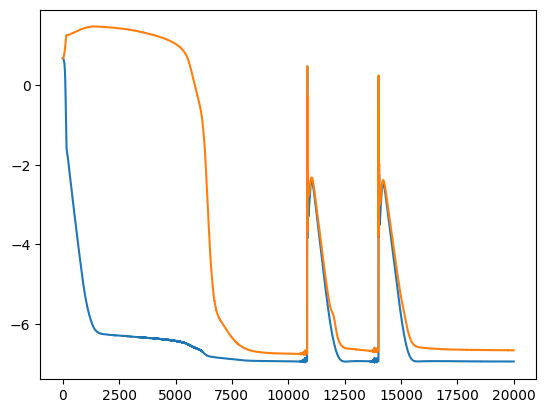

In [13]:
set_seed(seed)
model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln)
model.to('cuda');

save_dict=torch.load(root/run_name/'final.pth')
model.load_state_dict(save_dict['model'])

plt.plot(np.log10(save_dict['train_losses'])); plt.plot(np.log10(save_dict['test_losses']))

### Cosine, first embedding vec

In [ ]:
train_step=10000
save_dict_2=torch.load(root/run_name/(str(train_step)+'.pth'))
model.load_state_dict(save_dict_2['model'])

all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
cache = {}
model.remove_all_hooks()
model.cache_all(cache)

original_logits = model(all_data)[:, -1]
# Remove equals sign from output logits
original_logits = original_logits[:, :-1]

X=einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu()[:,0, 0, :]

# probe_W, probe_b, pred_1 = compute_probe(X, p, k=6)
# alpha=0.01
sparse_model, pred, target = sparse_probe(X, k=4, alpha=0.001, func='cos')

neuron_idx=0
plt.plot(pred)

Ok I'm not going to worry about recomputing the probe as the model trains

In [22]:
preds=[]
for train_step in tqdm.tqdm(range(0, 10000, 10)):
    save_dict_2=torch.load(root/run_name/(str(train_step)+'.pth'))
    model.load_state_dict(save_dict_2['model'])
    
    all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
    labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
    cache = {}
    model.remove_all_hooks()
    model.cache_all(cache)
    
    original_logits = model(all_data)[:, -1]
    # Remove equals sign from output logits
    original_logits = original_logits[:, :-1]
    
    X=einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu()[:,0, 0, :]
    
    pred = sparse_model.predict(X.numpy())
    preds.append(pred)
preds=np.array(preds)

np.save(str(root/run_name)+'/training_sparse_probe_cos_0', preds)

  0%|          | 0/1000 [00:00<?, ?it/s]

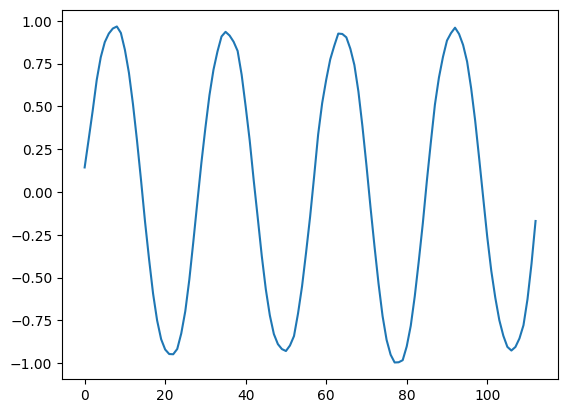

In [28]:
#Sin embedding vector 0 
train_step=10000
save_dict_2=torch.load(root/run_name/(str(train_step)+'.pth'))
model.load_state_dict(save_dict_2['model'])

all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
cache = {}
model.remove_all_hooks()
model.cache_all(cache)

original_logits = model(all_data)[:, -1]
original_logits = original_logits[:, :-1]

X=einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu()[:,0, 0, :]
sparse_model, pred, target = sparse_probe(X, k=4, alpha=0.001, func='sin')

plt.plot(pred)

In [29]:
np.sum(np.abs(sparse_model.coef_) > 1e-8)

8

In [30]:
preds=[]
for train_step in tqdm.tqdm(range(0, 10000, 10)):
    save_dict_2=torch.load(root/run_name/(str(train_step)+'.pth'))
    model.load_state_dict(save_dict_2['model'])
    
    all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
    labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
    cache = {}
    model.remove_all_hooks()
    model.cache_all(cache)
    
    original_logits = model(all_data)[:, -1]
    # Remove equals sign from output logits
    original_logits = original_logits[:, :-1]
    
    X=einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu()[:,0, 0, :]
    
    pred = sparse_model.predict(X.numpy())
    preds.append(pred)
preds=np.array(preds)

np.save(str(root/run_name)+'/training_sparse_probe_sin_0', preds)

  0%|          | 0/1000 [00:00<?, ?it/s]

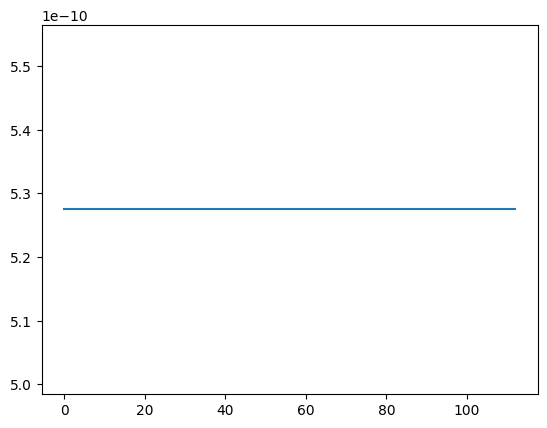

In [31]:
#cos embedding vector 1
train_step=10000
save_dict_2=torch.load(root/run_name/(str(train_step)+'.pth'))
model.load_state_dict(save_dict_2['model'])

all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
cache = {}
model.remove_all_hooks()
model.cache_all(cache)

original_logits = model(all_data)[:, -1]
original_logits = original_logits[:, :-1]

X=einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu()[0,:, 0, :]
sparse_model, pred, target = sparse_probe(X, k=4, alpha=0.001, func='cos')

plt.plot(pred)

In [32]:
np.sum(np.abs(sparse_model.coef_) > 1e-8)

0

In [33]:
preds=[]
for train_step in tqdm.tqdm(range(0, 10000, 10)):
    save_dict_2=torch.load(root/run_name/(str(train_step)+'.pth'))
    model.load_state_dict(save_dict_2['model'])
    
    all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
    labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
    cache = {}
    model.remove_all_hooks()
    model.cache_all(cache)
    
    original_logits = model(all_data)[:, -1]
    # Remove equals sign from output logits
    original_logits = original_logits[:, :-1]
    
    X=einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu()[0,:, 0, :]
    
    pred = sparse_model.predict(X.numpy())
    preds.append(pred)
preds=np.array(preds)

np.save(str(root/run_name)+'/training_sparse_probe_cos_1', preds)

  0%|          | 0/1000 [00:00<?, ?it/s]

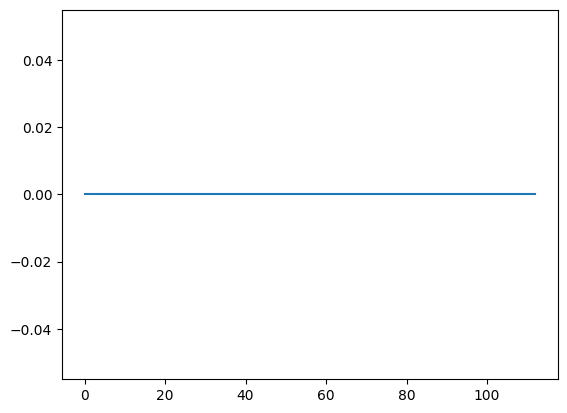

In [34]:
#Sin embedding vector 1
train_step=10000
save_dict_2=torch.load(root/run_name/(str(train_step)+'.pth'))
model.load_state_dict(save_dict_2['model'])

all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
cache = {}
model.remove_all_hooks()
model.cache_all(cache)

original_logits = model(all_data)[:, -1]
original_logits = original_logits[:, :-1]

X=einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu()[0,:, 0, :]
sparse_model, pred, target = sparse_probe(X, k=4, alpha=0.001, func='sin')

plt.plot(pred)

In [35]:
np.sum(np.abs(sparse_model.coef_) > 1e-8)

0

In [36]:
preds=[]
for train_step in tqdm.tqdm(range(0, 10000, 10)):
    save_dict_2=torch.load(root/run_name/(str(train_step)+'.pth'))
    model.load_state_dict(save_dict_2['model'])
    
    all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
    labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
    cache = {}
    model.remove_all_hooks()
    model.cache_all(cache)
    
    original_logits = model(all_data)[:, -1]
    # Remove equals sign from output logits
    original_logits = original_logits[:, :-1]
    
    X=einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu()[0,:, 0, :]
    
    pred = sparse_model.predict(X.numpy())
    preds.append(pred)
preds=np.array(preds)

np.save(str(root/run_name)+'/training_sparse_probe_sin_1', preds)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Now Surface Time I reckin
- Hidden neurons 341 and 106
- Heatmaps and values
- MLP output 1
- Logitc 7
- Let's go!

In [42]:
# os.mkdir(root/run_name/'training_heatmaps')

In [14]:
neuron_idx = 341
surf_vals = []

all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)], device="cuda")
# labels = ...  # remove if unused

for train_step in tqdm.tqdm(range(0, 10000, 10)):
    save_dict_2 = torch.load(root/run_name/(str(train_step)+".pth"), map_location="cpu")
    model.load_state_dict(save_dict_2["model"])
    del save_dict_2

    cache = {}
    model.remove_all_hooks()
    model.cache_all(cache)

    with torch.no_grad():
        _ = model(all_data)   # run forward to populate cache

    t = cache["blocks.0.mlp.hook_pre"][:, 2, neuron_idx]   # slice on GPU
    img = t.reshape(p, p).detach().cpu().numpy()
    surf_vals.append(img)

    # plot
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(np.rot90(img.T))
    fig.savefig(
        str(root/run_name/"training_heatmaps"/f"mlp_pre_{train_step:04d}_{neuron_idx:03d}.png"),
        bbox_inches="tight", pad_inches=0, dpi=300
    )
    plt.close(fig)

    # cleanup
    del cache, t
    # torch.cuda.empty_cache()  # optional

surf_vals = np.array(surf_vals)
np.save(str(root/run_name/f"training_mlp_pre{neuron_idx:03d}"), surf_vals)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
neuron_idx = 106
surf_vals = []

all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)], device="cuda")
# labels = ...  # remove if unused

for train_step in tqdm.tqdm(range(0, 10000, 10)):
    save_dict_2 = torch.load(root/run_name/(str(train_step)+".pth"), map_location="cpu")
    model.load_state_dict(save_dict_2["model"])
    del save_dict_2

    cache = {}
    model.remove_all_hooks()
    model.cache_all(cache)

    with torch.no_grad():
        _ = model(all_data)   # run forward to populate cache

    t = cache["blocks.0.mlp.hook_pre"][:, 2, neuron_idx]   # slice on GPU
    img = t.reshape(p, p).detach().cpu().numpy()
    surf_vals.append(img)

    # plot
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(np.rot90(img.T))
    fig.savefig(
        str(root/run_name/"training_heatmaps"/f"mlp_pre_{train_step:04d}_{neuron_idx:03d}.png"),
        bbox_inches="tight", pad_inches=0, dpi=300
    )
    plt.close(fig)

    # cleanup
    del cache, t
    # torch.cuda.empty_cache()  # optional

surf_vals = np.array(surf_vals)
np.save(str(root/run_name/f"training_mlp_pre{neuron_idx:03d}"), surf_vals)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
neuron_idx = 1
surf_vals = []

all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)], device="cuda")
# labels = ...  # remove if unused

for train_step in tqdm.tqdm(range(0, 10000, 10)):
    save_dict_2 = torch.load(root/run_name/(str(train_step)+".pth"), map_location="cpu")
    model.load_state_dict(save_dict_2["model"])
    del save_dict_2

    cache = {}
    model.remove_all_hooks()
    model.cache_all(cache)

    with torch.no_grad():
        _ = model(all_data)   # run forward to populate cache

    t = cache["blocks.0.hook_mlp_out"][:, 2, neuron_idx]   # slice on GPU
    img = t.reshape(p, p).detach().cpu().numpy()
    surf_vals.append(img)

    # plot
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(np.rot90(img.T))
    fig.savefig(
        str(root/run_name/"training_heatmaps"/f"mlp_out_{train_step:04d}_{neuron_idx:03d}.png"),
        bbox_inches="tight", pad_inches=0, dpi=300
    )
    plt.close(fig)

    # cleanup
    del cache, t
    # torch.cuda.empty_cache()  # optional

surf_vals = np.array(surf_vals)
np.save(str(root/run_name/f"training_mlp_out{neuron_idx:03d}"), surf_vals)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
neuron_idx = 7
surf_vals = []

all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)], device="cuda")
# labels = ...  # remove if unused

for train_step in tqdm.tqdm(range(0, 10000, 10)):
    save_dict_2 = torch.load(root/run_name/(str(train_step)+".pth"), map_location="cpu")
    model.load_state_dict(save_dict_2["model"])
    del save_dict_2

    cache = {}
    model.remove_all_hooks()
    model.cache_all(cache)

    with torch.no_grad():
        logits = model(all_data)   # run forward to populate cache

    t = logits[:, 2, neuron_idx]   # slice on GPU
    #Ok need to hack briefly on logit dims here, and should be off to the races then. 
    
    img = t.reshape(p, p).detach().cpu().numpy()
    surf_vals.append(img)

    # plot
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(np.rot90(img.T))
    fig.savefig(
        str(root/run_name/"training_heatmaps"/f"logits_{train_step:04d}_{neuron_idx:03d}.png"),
        bbox_inches="tight", pad_inches=0, dpi=300
    )
    plt.close(fig)

    # cleanup
    del cache, t
    # torch.cuda.empty_cache()  # optional

surf_vals = np.array(surf_vals)
np.save(str(root/run_name/f"logits{neuron_idx:03d}"), surf_vals)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
logits = model(all_data)

In [19]:
logits.shape

torch.Size([12769, 3, 114])

In [ ]:
# neuron_idx=341
# surf_vals=[]
# for train_step in tqdm.tqdm(range(0, 10000, 10)):
#     save_dict_2=torch.load(root/run_name/(str(train_step)+'.pth'))
#     model.load_state_dict(save_dict_2['model'])
    
#     all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
#     labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
#     cache = {}
#     model.remove_all_hooks()
#     model.cache_all(cache)
    
#     original_logits = model(all_data)[:, -1]
#     # Remove equals sign from output logits
#     original_logits = original_logits[:, :-1]
    
#     mr = einops.rearrange(cache['blocks.0.mlp.hook_pre'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy() 
#     surf_vals.append(mr[:,:,2,neuron_idx])
    
#     plt.clf()
#     plt.figure(frameon=False)
#     ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
#     ax.set_axis_off()
#     plt.gcf().add_axes(ax)
#     plt.imshow(np.rot90(mr[:,:,2,neuron_idx].T)) #have to transpose if transposing u and v and param_surface_1
#     plt.savefig(str(root/run_name/'training_heatmaps')+'/mlp_pre_'+str(train_step).zfill(4)+'_'+str(neuron_idx).zfill(3)+'.png', bbox_inches='tight', pad_inches=0, dpi=300)
#     plt.close()
    
# surf_vals=np.array(surf_vals)
# np.save(str(root/run_name)+'/training_mlp_pre'+str(neuron_idx).zfill(3), surf_vals)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# neuron_idx=106
# surf_vals=[]
# for train_step in tqdm.tqdm(range(0, 10000, 10)):
#     save_dict_2=torch.load(root/run_name/(str(train_step)+'.pth'))
#     model.load_state_dict(save_dict_2['model'])
    
#     all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
#     labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
#     cache = {}
#     model.remove_all_hooks()
#     model.cache_all(cache)
    
#     original_logits = model(all_data)[:, -1]
#     # Remove equals sign from output logits
#     original_logits = original_logits[:, :-1]
    
#     mr = einops.rearrange(cache['blocks.0.mlp.hook_pre'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy() 
#     surf_vals.append(mr[:,:,2,neuron_idx])
    
#     plt.clf()
#     plt.figure(frameon=False)
#     ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
#     ax.set_axis_off()
#     plt.gcf().add_axes(ax)
#     plt.imshow(np.rot90(mr[:,:,2,neuron_idx].T)) #have to transpose if transposing u and v and param_surface_1
#     plt.savefig(str(root/run_name/'training_heatmaps')+'/mlp_pre_'+str(train_step).zfill(4)+'_'+str(neuron_idx).zfill(3)+'.png', bbox_inches='tight', pad_inches=0, dpi=300)
#     plt.close()
    
# surf_vals=np.array(surf_vals)
# np.save(str(root/run_name)+'/training_mlp_pre'+str(neuron_idx).zfill(3), surf_vals)

In [ ]:
# neuron_idx=1
# surf_vals=[]
# for train_step in tqdm.tqdm(range(0, 10000, 10)):
#     save_dict_2=torch.load(root/run_name/(str(train_step)+'.pth'))
#     model.load_state_dict(save_dict_2['model'])
    
#     all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
#     labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
#     cache = {}
#     model.remove_all_hooks()
#     model.cache_all(cache)
    
#     original_logits = model(all_data)[:, -1]
#     # Remove equals sign from output logits
#     original_logits = original_logits[:, :-1]
    
#     mr = einops.rearrange(cache['blocks.0.mlp.hook_mlp_out'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy() 
#     surf_vals.append(mr[:,:,2,neuron_idx])
    
#     plt.clf()
#     plt.figure(frameon=False)
#     ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
#     ax.set_axis_off()
#     plt.gcf().add_axes(ax)
#     plt.imshow(np.rot90(mr[:,:,2,neuron_idx].T)) #have to transpose if transposing u and v and param_surface_1
#     plt.savefig(str(root/run_name/'training_heatmaps')+'/mlp_pre_'+str(train_step).zfill(4)+'_'+str(neuron_idx).zfill(3)+'.png', bbox_inches='tight', pad_inches=0, dpi=300)
#     plt.close()
    
# surf_vals=np.array(surf_vals)
# np.save(str(root/run_name)+'/training_mlp_pre'+str(neuron_idx).zfill(3), surf_vals)